In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir("C:/Users/joseh/OneDrive - Universidad de los Andes\MIAD\Proyecto de grado/ElectroDunas")
import Funciones_Procesamiento as fp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, Birch, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pickle
from tqdm import tqdm

In [2]:
# Ruta de la carpeta que contiene los archivos CSV
carpeta = './Datos Electro Dunas'

# Diccionario para almacenar los DataFrames con nombres originales como claves
dataframes_dict = {}

# Recorre todos los archivos en la carpeta
for archivo in os.listdir(carpeta):
    # Verifica que el archivo sea un archivo CSV
    if archivo.endswith('.csv'):
        # Construye la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta, archivo)
        
        # Lee el archivo CSV y lo agrega al diccionario
        df = pd.read_csv(ruta_archivo)
        dataframes_dict[archivo] = df

Este código verifica si todos los DataFrames en el diccionario tienen las mismas columnas. Esto para asegurarse de que los datos de diferentes archivos son consistentes y se pueden combinar o comparar de manera segura:

In [3]:
# Verifica que todas las bases de datos tengan el mismo número de columnas
columnas_primer_df = set(dataframes_dict[list(dataframes_dict.keys())[0]].columns)
todas_las_columnas_coinciden = all(
    set(df.columns) == columnas_primer_df for df in dataframes_dict.values()
)

# Imprime el resultado
if todas_las_columnas_coinciden:
    print("Todas las DataFrames tienen las mismas columnas.")
else:
    print("Las columnas de las DataFrames no coinciden.")

Todas las DataFrames tienen las mismas columnas.


Este código verifica si todas las fechas en todos los DataFrames tienen el formato correcto. Si no es así, intenta convertir las fechas al formato correcto y maneja los errores reemplazando las fechas no válidas con valores nulos:

In [4]:
# Verifica que todas las observaciones en la columna de fechas tengan el mismo formato
formato_fecha = "%Y-%m-%d %H:%M:%S"
todas_las_fechas_coinciden = all(
    all(pd.to_datetime(df['Fecha'], format=formato_fecha, errors='coerce').notnull())
    for df in dataframes_dict.values()
)

# Imprime el resultado
if todas_las_fechas_coinciden:
    print("Todas las observaciones en la columna de fechas tienen el mismo formato.")
else:
    print("NO todas las observaciones en la columna de fechas tienen el mismo formato. Se inicia proceso de transformación al formato ideal.")
    # Itera sobre cada DataFrame en el diccionario
    for nombre, df in dataframes_dict.items():
        try:
            # Intenta convertir las fechas al formato especificado
            df['Fecha'] = pd.to_datetime(df['Fecha'], format=formato_fecha)
        except ValueError as e:
            print(f"Error al convertir las fechas en el DataFrame {nombre}: {e}")
            # Aquí puedes manejar el error como prefieras
            # Por ejemplo, podrías reemplazar las fechas no válidas con NaT
            df['Fecha'] = pd.to_datetime(df['Fecha'], format=formato_fecha, errors='coerce')
        
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

Todas las observaciones en la columna de fechas tienen el mismo formato.


En este código, realizamos una verificación para detectar la presencia de datos faltantes. Si se encuentran tales datos, aplicamos un método de imputación basado en los K-Vecinos Más Cercanos (KNN), específicamente utilizando los tres vecinos más cercanos para tratar estos datos faltantes. La fortaleza de este método radica en su capacidad para preservar las relaciones entre las variables, manejar outliers y adaptarse a diferentes distribuciones de datos, por lo que este enfoque puede ser particularmente efectivo para imputar datos faltantes en variables como la energía activa, la energía reactiva o el voltaje.

In [5]:
# Crea el imputador KNN
imputador = KNNImputer(n_neighbors=3)

# Inicializa un contador para los datos faltantes
contador_datos_faltantes = 0

# Itera sobre cada DataFrame en el diccionario
for nombre, df in dataframes_dict.items():
    # Cuenta los datos faltantes en el DataFrame actual
    datos_faltantes = df.isnull().sum().sum()
    
    # Agrega al contador
    contador_datos_faltantes += datos_faltantes
    
    # Separa la columna 'Fecha'
    fechas = df['Fecha']
    df = df.drop(columns='Fecha')
    
    # Imputa los datos faltantes con el imputador KNN
    df_imputado = imputador.fit_transform(df)
    
    # Convierte el resultado (que es un array de numpy) de nuevo a un DataFrame
    df = pd.DataFrame(df_imputado, columns=df.columns)
    
    # Vuelve a añadir la columna 'Fecha'
    df['Fecha'] = fechas
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

# Imprime el número total de datos faltantes que se tuvieron que cambiar
print(f"Se tuvieron que cambiar {contador_datos_faltantes} datos faltantes.")

Se tuvieron que cambiar 0 datos faltantes.


Se agrega la columna cliente a cada dataframe:

In [6]:
# Itera sobre cada DataFrame en el diccionario
for nombre, df in dataframes_dict.items():
    # Extrae el número de cliente del nombre del archivo
    numero_cliente = int(nombre.split('CLIENTE')[1].split('.')[0])
    
    # Añade la columna 'Cliente' usando el número de cliente
    df['Cliente'] = f"Cliente {numero_cliente}"
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

En los siguientes códigos cargamos, modificamos y agregamos a cada dataframe el sector económico de cada cliente:

In [7]:
# Ruta del archivo CSV con las clasificaciones de sector económico
ruta_archivo_sector = './Datos Electro Dunas/sector_economico_clientes.xlsx'

df_sector = pd.read_excel(ruta_archivo_sector)

# Cambia los nombres de las columnas
nuevos_nombres = ['Cliente', 'Sector']  # Lista con los nuevos nombres
df_sector.columns = nuevos_nombres

df_sector['Cliente'] = df_sector['Cliente'].apply(lambda x: "Cliente " + str(x.split(' ')[1]))

df_sector.head()

Cliente                                             Sector
0  Cliente 1  Elaboración de cacao y chocolate y de producto...
1  Cliente 2  Elaboración de cacao y chocolate y de producto...
2  Cliente 3  Elaboración de cacao y chocolate y de producto...
3  Cliente 4  Elaboración de cacao y chocolate y de producto...
4  Cliente 5  Elaboración de cacao y chocolate y de producto...

In [8]:
# Itera sobre cada DataFrame en el diccionario para agregar la columna sector
for nombre, df in dataframes_dict.items():
    # Combina el DataFrame con df_sector basándose en la columna 'Cliente'
    df_combinado = pd.merge(df, df_sector, on='Cliente', how='left')
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df_combinado

In [9]:
df=dataframes_dict["DATOSCLIENTE1.csv"]
df.head()

Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  \
0       0.357841         0.282788  455.139171  510.561002   
1       0.372264         0.431377  469.978787  469.917178   
2       1.044687         0.338626  468.721120  546.949147   
3       0.566425         0.495791  452.329255  444.122989   
4       1.080556         0.472018  513.477596  535.463719   

                 Fecha    Cliente  \
0  2021-01-01 00:00:00  Cliente 1   
1  2021-01-01 01:00:00  Cliente 1   
2  2021-01-01 02:00:00  Cliente 1   
3  2021-01-01 03:00:00  Cliente 1   
4  2021-01-01 04:00:00  Cliente 1   

                                              Sector  
0  Elaboración de cacao y chocolate y de producto...  
1  Elaboración de cacao y chocolate y de producto...  
2  Elaboración de cacao y chocolate y de producto...  
3  Elaboración de cacao y chocolate y de producto...  
4  Elaboración de cacao y chocolate y de producto...

Dado que nuestro objetivo es detectar anomalías en la energía activa, reactiva y el voltaje, podemos representar estos elementos en un triángulo de potencias. En este triángulo, la potencia aparente forma la hipotenusa, mientras que las potencias activa y reactiva corresponden a los catetos adyacente y opuesto, respectivamente.

El Factor de Potencia (FP), que es la relación entre la potencia activa y la potencia aparente, nos ayuda a entender qué tan eficientemente se está utilizando la energía. Un FP cercano a 1 indica que la mayor parte de la energía se está convirtiendo en trabajo útil. Sin embargo, un FP significativamente menor que 1 puede ser una señal de anomalía, ya que implica que una gran cantidad de energía se está almacenando y liberada sin realizar trabajo útil.

Por lo tanto, monitorear el FP puede ser una estrategia efectiva para detectar anomalías en nuestro experimento. En el siguiente código, calcularemos y añadiremos a los dataframes las columnas Potencia Aparente y Factor Potencia:

In [10]:
# Añadimos la columna Potencia aparente y el factor potencia a cada DataFrame en el diccionario
for df in dataframes_dict.values():
    df['Potencia_Aparente'] = np.sqrt(df['Active_energy']**2 + df['Reactive_energy']**2)
    df['Factor_Potencia_%'] = (df['Active_energy'] / (df['Potencia_Aparente'] + 1e-10))

En el contexto de nuestro experimento, estamos analizando las variables Voltaje_FA y Voltaje_FC, que representan medidas de voltaje en un sistema eléctrico trifásico. Un sistema trifásico consta de tres corrientes alternas (AC) que se desplazan en el tiempo, comúnmente denominadas Fase A, Fase B y Fase C. Estas mediciones de voltaje son cruciales para comprender el comportamiento del sistema eléctrico y asegurar que los dispositivos conectados a cada fase funcionen correctamente.

Un aspecto importante a considerar es el desequilibrio de voltaje, que es la discrepancia en la tensión entre las fases de un sistema trifásico. Este desequilibrio puede afectar negativamente el rendimiento y acortar la vida útil de los motores trifásicos. Además, puede causar un rendimiento deficiente o fallos prematuros en los motores trifásicos y otras cargas trifásicas.

En nuestros datos, contamos solamente con las mediciones de voltaje para las Fases A y C (Voltaje_FA y Voltaje_FC). Si estos voltajes presentan diferencias significativas, esto podría indicar un desequilibrio en el sistema. Además, si notamos que estos voltajes varían de manera inconsistente con el tiempo, esto también podría ser una señal de un problema potencial en el sistema.

Dado lo anterior, vamos a agregar una columna con el desequilibrio del voltaje y otra en su equivalente como un porcentaje:

In [11]:
# Añadimos la columna Desequilibrio voltaje a cada DataFrame en el diccionario
for df in dataframes_dict.values():
    df['Desequilibrio_Voltaje'] = abs(df['Voltaje_FA'] - df['Voltaje_FC'])
    df['Desequilibrio_Voltaje_%'] = (df['Desequilibrio_Voltaje'] / (df[['Voltaje_FA', 'Voltaje_FC']].min(axis=1) + 1e-10))

Le damos un vistazo a algunos dataframes como ejemplo:

In [12]:
df_c1=dataframes_dict["DATOSCLIENTE1.csv"]
df_c1.head()

Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  \
0       0.357841         0.282788  455.139171  510.561002   
1       0.372264         0.431377  469.978787  469.917178   
2       1.044687         0.338626  468.721120  546.949147   
3       0.566425         0.495791  452.329255  444.122989   
4       1.080556         0.472018  513.477596  535.463719   

                 Fecha    Cliente  \
0  2021-01-01 00:00:00  Cliente 1   
1  2021-01-01 01:00:00  Cliente 1   
2  2021-01-01 02:00:00  Cliente 1   
3  2021-01-01 03:00:00  Cliente 1   
4  2021-01-01 04:00:00  Cliente 1   

                                              Sector  Potencia_Aparente  \
0  Elaboración de cacao y chocolate y de producto...           0.456091   
1  Elaboración de cacao y chocolate y de producto...           0.569796   
2  Elaboración de cacao y chocolate y de producto...           1.098198   
3  Elaboración de cacao y chocolate y de producto...           0.752759   
4  Elaboración de cacao y chocolate y de producto...           1.179154   

   Factor_Potencia_%  Desequilibrio_Voltaje  Desequilibrio_Voltaje_%  
0           0.784582              55.421831                 0.121769  
1           0.653329               0.061610                 0.000131  
2           0.951274              78.228027                 0.166897  
3           0.752465               8.206266                 0.018477  
4           0.916383              21.986123                 0.042818

Agregamos todas las columnas de fechas a cada dataframe:

In [13]:
# Agregar columna de fecha a cada DataFrame
for nombre, df in dataframes_dict.items():
    dataframes_dict[nombre] = fp.agregar_col_fecha(df)

In [14]:
df_c1=dataframes_dict["DATOSCLIENTE10.csv"]
df_c1.head()

Active_energy  Reactive_energy   Voltaje_FA   Voltaje_FC       Fecha  \
0       2.873046         0.508548  1557.057893  1312.106981  01/01/2021   
1       2.037791         0.532105  1456.095693  1329.850730  01/01/2021   
2       2.358945         0.797515  1226.481132  1301.578937  01/01/2021   
3       1.347161         0.472839  1138.403031  1379.538878  01/01/2021   
4       2.486699         0.488362  1062.467048  1594.077359  01/01/2021   

      Cliente                                Sector  Potencia_Aparente  \
0  Cliente 10  Cultivo de Árboles Frutales y Nueces           2.917707   
1  Cliente 10  Cultivo de Árboles Frutales y Nueces           2.106117   
2  Cliente 10  Cultivo de Árboles Frutales y Nueces           2.490110   
3  Cliente 10  Cultivo de Árboles Frutales y Nueces           1.427733   
4  Cliente 10  Cultivo de Árboles Frutales y Nueces           2.534200   

   Factor_Potencia_%  Desequilibrio_Voltaje  Desequilibrio_Voltaje_%  Mes  \
0           0.984693             244.950912                 0.186685    1   
1           0.967558             126.244963                 0.094932    1   
2           0.947325              75.097805                 0.061230    1   
3           0.943567             241.135848                 0.211819    1   
4           0.981256             531.610311                 0.500355    1   

    Año  Dia  Hora Nombre_dia  Fin_de_semana  Horario_laboral  Dia_semana  
0  2021    1     0     Friday              0                0           4  
1  2021    1     1     Friday              0                0           4  
2  2021    1     2     Friday              0                0           4  
3  2021    1     3     Friday              0                0           4  
4  2021    1     4     Friday              0                0           4

Consolidamos en una sola dataframe todos los clientes y sectores:

In [15]:
df_consolidado = pd.concat(dataframes_dict.values(), ignore_index=True)

# Finalmente, guardamos el dataframe consolidado en un archivo .csv
df_consolidado.to_csv('Dataframes_all_consolidated.csv', index=False)

Exploramos los datos:
Primero exploramos la correlación de las variables iniciales y las nuevas de Factor de potencia y desequilibrio de voltaje.

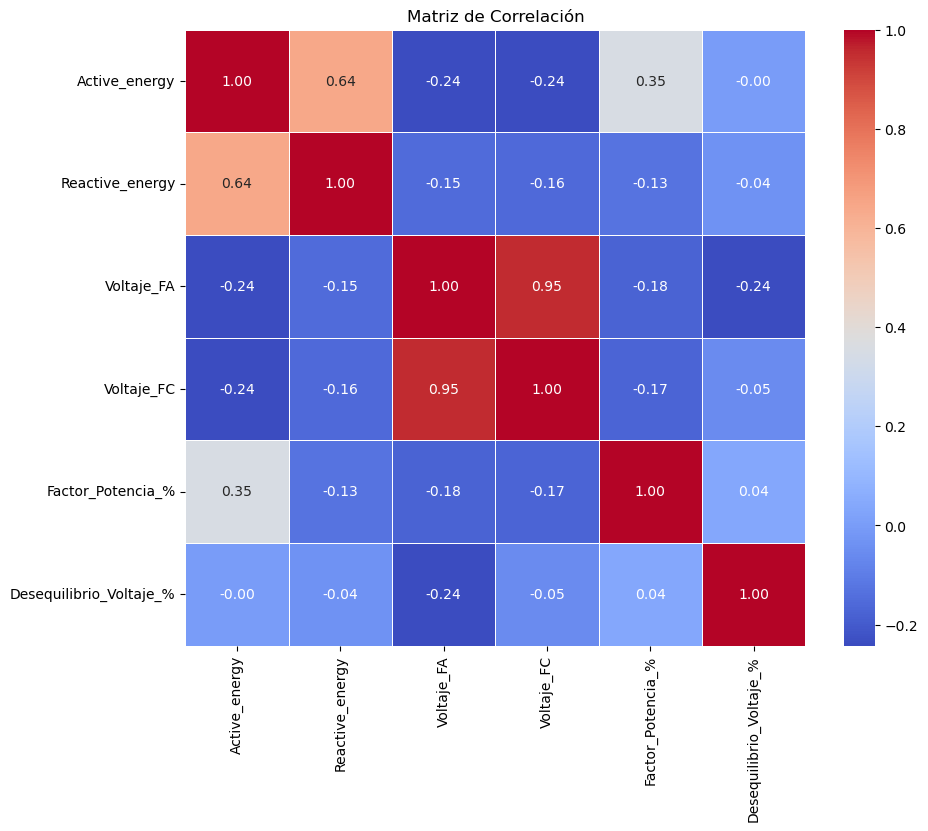

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated.csv')

# Seleccionar las columnas que te interesan
cols = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia_%', 'Desequilibrio_Voltaje_%']
df_subset = df[cols]

# Calcular la matriz de correlación
corr_matrix = df_subset.corr()

# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()


Exploramos la distribución de frecuencias del factor de potencia (FP) y el desequilibrio de voltaje (DV) GLOBALES:

- Encontramos valores negativos de FP.
- Encontramos valores extremos DV.

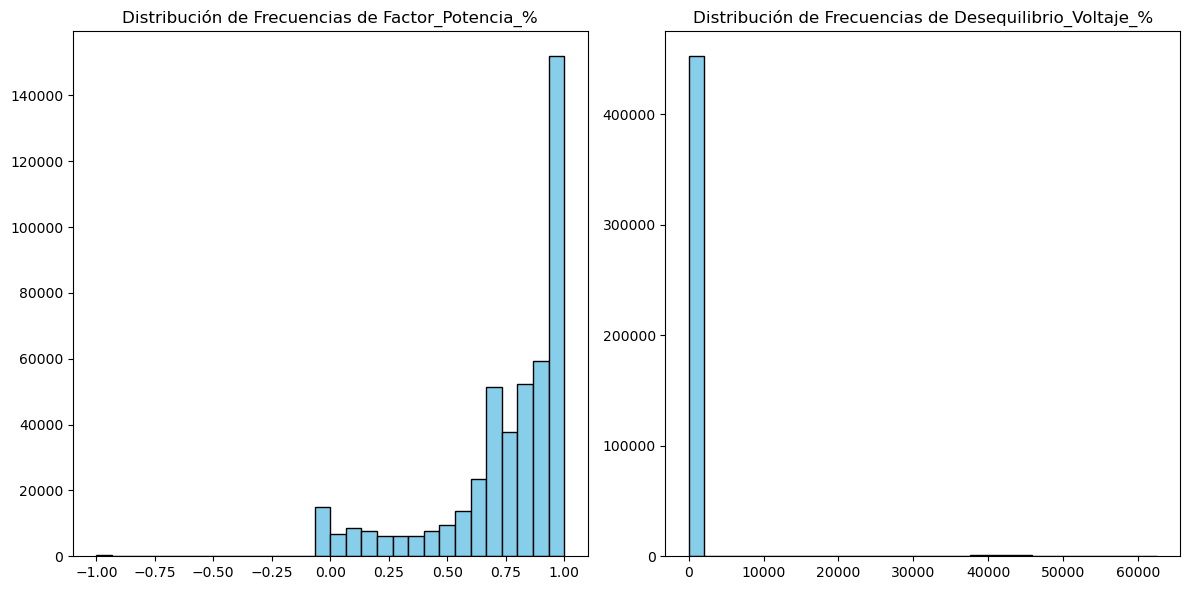

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated.csv')

# Crear una figura con múltiples subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Crear un histograma para 'Factor_Potencia_%'
axs[0].hist(df['Factor_Potencia_%'], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribución de Frecuencias de Factor_Potencia_%')

# Crear un histograma para 'Desequilibrio_Voltaje_%'
axs[1].hist(df['Desequilibrio_Voltaje_%'], bins=30, color='skyblue', edgecolor='black')
axs[1].set_title('Distribución de Frecuencias de Desequilibrio_Voltaje_%')

# Mostrar la figura con todos los subplots
plt.tight_layout()
plt.show()

Exploramos la distribución de frecuencias del FP por SECTOR:

- Valores negativos sector de agua.
- Valores extremos sector cultivo de árboles y nueces.

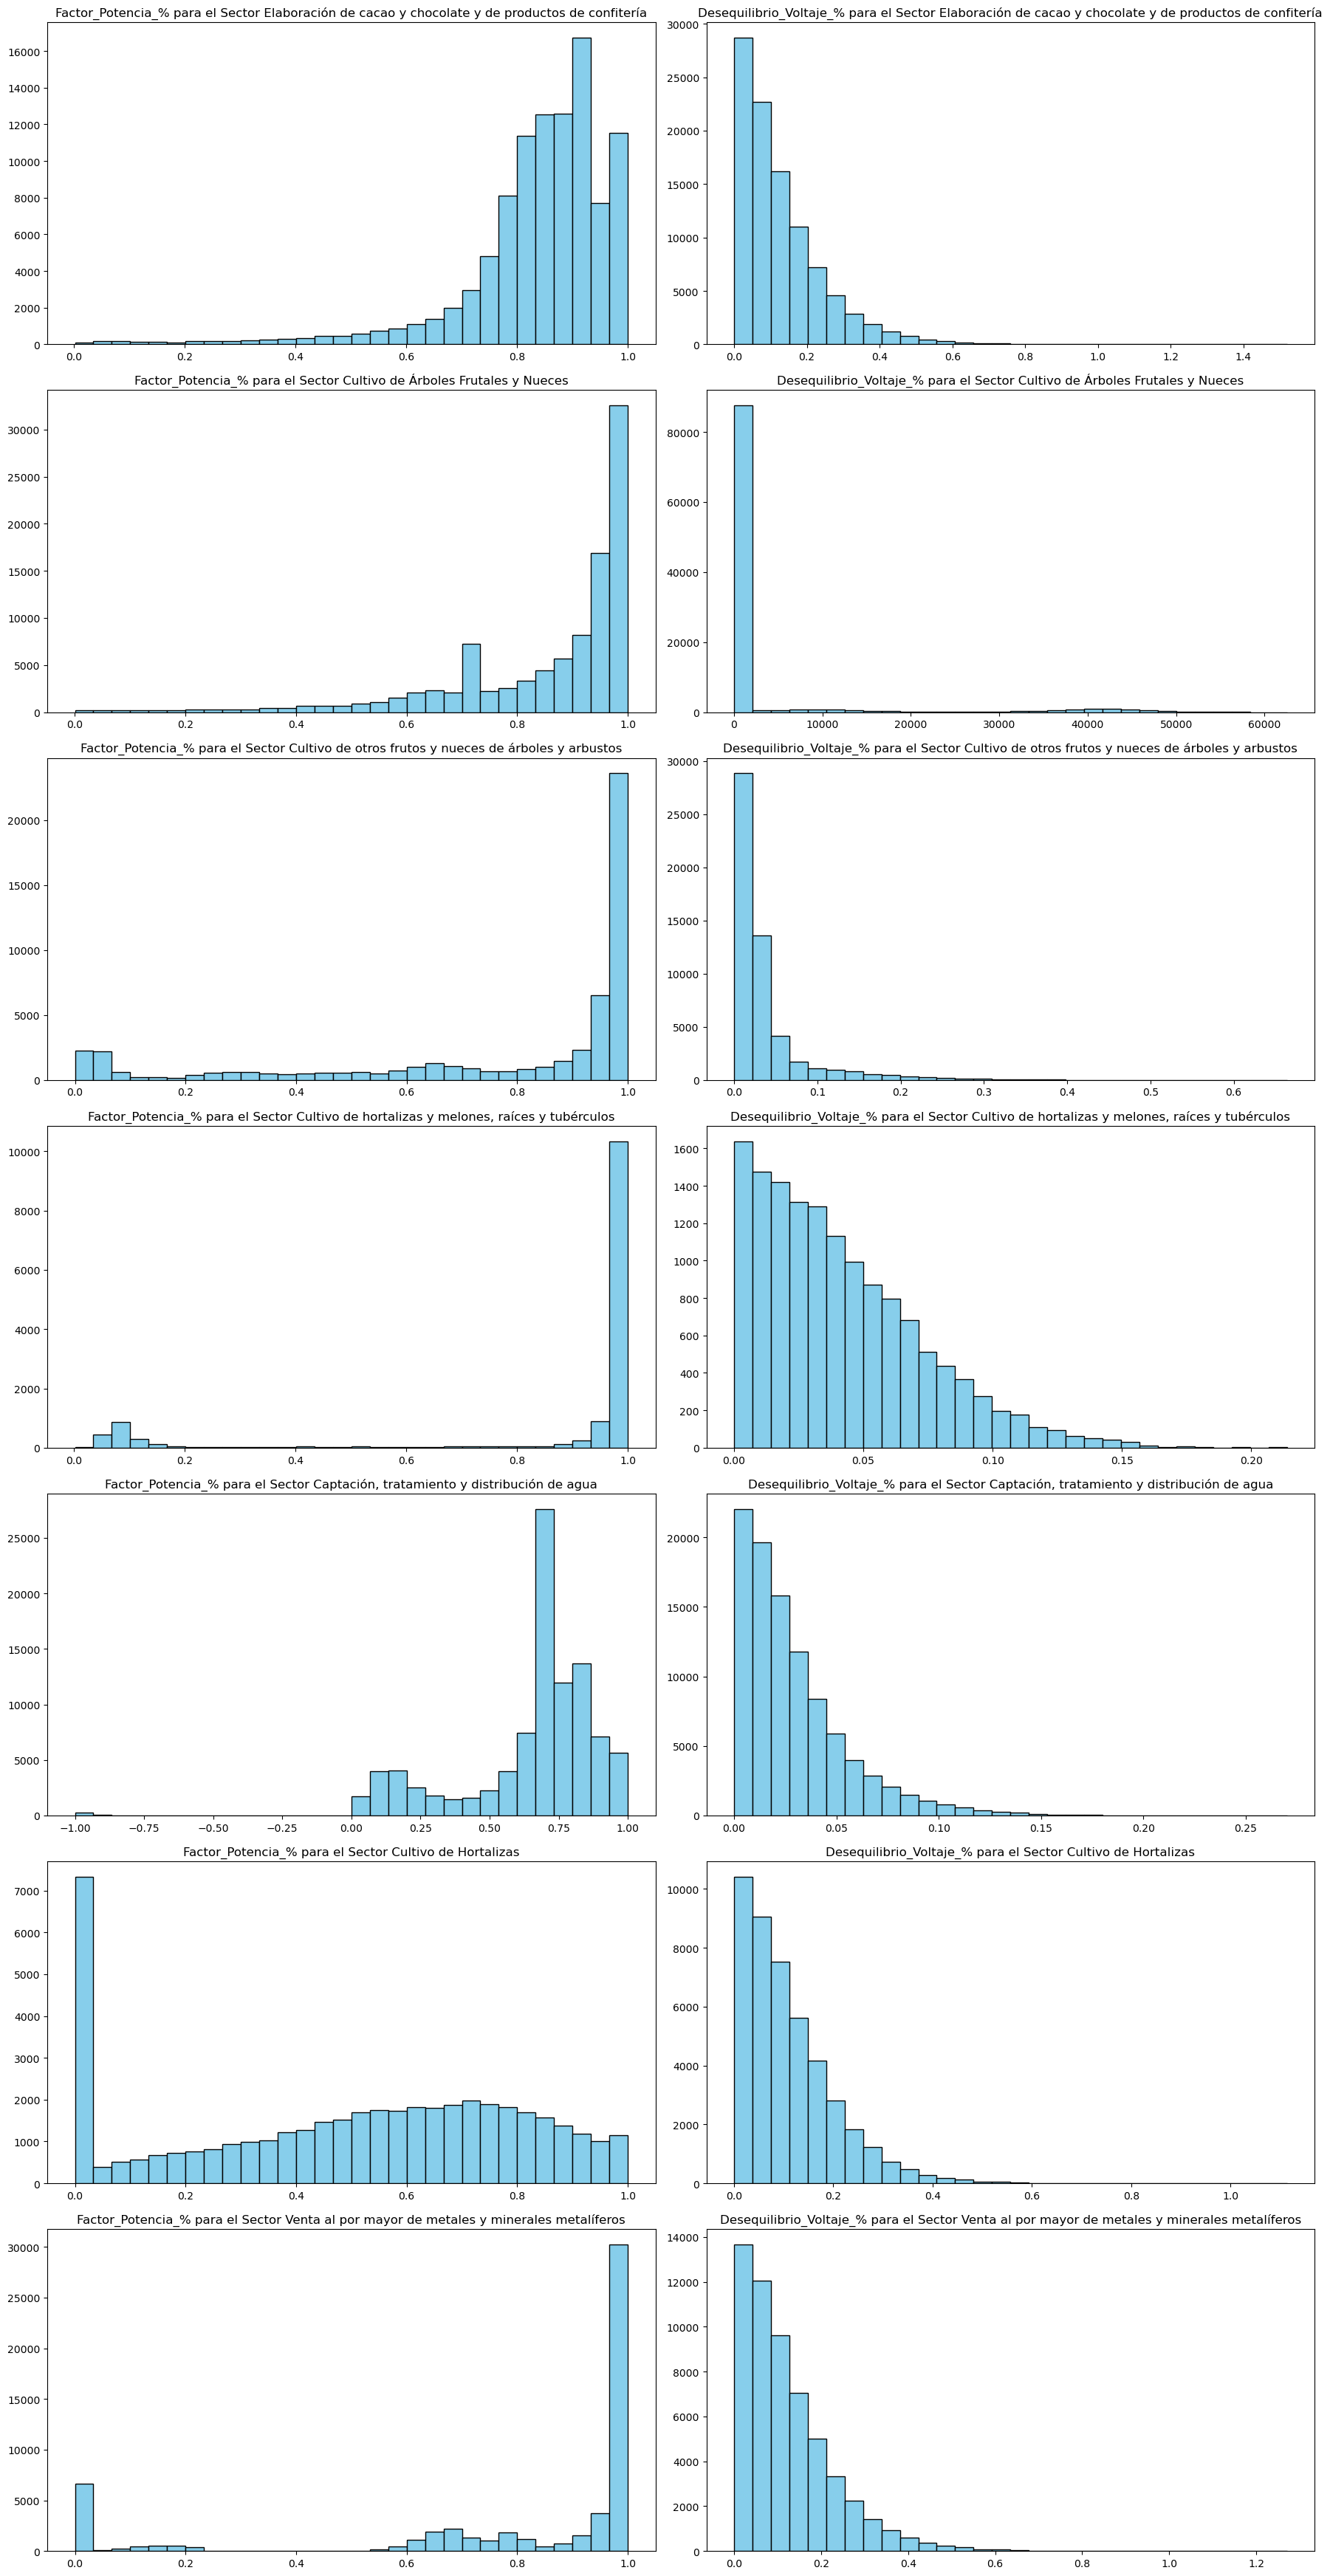

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated.csv')

# Obtener la lista de sectores únicos
sectores = df['Sector'].unique()

# Crear una figura con múltiples subplots
fig, axs = plt.subplots(len(sectores), 2, figsize=(18, 5*len(sectores)))

for i, sector in enumerate(sectores):
    # Filtrar el dataframe por sector
    df_sector = df[df['Sector'] == sector]

    # Crear un histograma para 'Factor_Potencia_%' para el sector actual
    axs[i, 0].hist(df_sector['Factor_Potencia_%'], bins=30, color='skyblue', edgecolor='black')
    axs[i, 0].set_title(f'Factor_Potencia_% para el Sector {sector}')

    # Crear un histograma para 'Desequilibrio_Voltaje_%' para el sector actual
    axs[i, 1].hist(df_sector['Desequilibrio_Voltaje_%'], bins=30, color='skyblue', edgecolor='black')
    axs[i, 1].set_title(f'Desequilibrio_Voltaje_% para el Sector {sector}')

# Mostrar la figura con todos los subplots
plt.tight_layout()
plt.show()


Exploramos la distribución de frecuencias del DV por SECTOR:

Tratamos los outliers (valores negativos y extremos) utilizando el método del rango intercuartil IQR GLOBALMENTE:

In [19]:
import pandas as pd
import numpy as np

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated.csv')

# Calcular el IQR para 'Factor_Potencia_%'
Q1 = df['Factor_Potencia_%'].quantile(0.25)
Q3 = df['Factor_Potencia_%'].quantile(0.75)
IQR = Q3 - Q1

# Identificar los outliers en 'Factor_Potencia_%'
df['Anomalia_FP'] = ((df['Factor_Potencia_%'] < (Q1 - 1.5 * IQR)) | (df['Factor_Potencia_%'] > (Q3 + 1.5 * IQR))).astype(np.int)

# Calcular el IQR para 'Desequilibrio_Voltaje_%'
Q1 = df['Desequilibrio_Voltaje_%'].quantile(0.25)
Q3 = df['Desequilibrio_Voltaje_%'].quantile(0.75)
IQR = Q3 - Q1

# Identificar los outliers en 'Desequilibrio_Voltaje_%'
df['Anomalias_Voltaje'] = ((df['Desequilibrio_Voltaje_%'] < (Q1 - 1.5 * IQR)) | (df['Desequilibrio_Voltaje_%'] > (Q3 + 1.5 * IQR))).astype(np.int)

# Guardar el dataframe modificado en un nuevo archivo .csv
df.to_csv('Dataframes_all_consolidated_sin_outliers_v1_IQR.csv', index=False)


C:\Users\joseh\AppData\Local\Temp\ipykernel_14744\2210129612.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['Anomalia_FP'] = ((df['Factor_Potencia_%'] < (Q1 - 1.5 * IQR)) | (df['Factor_Potencia_%'] > (Q3 + 1.5 * IQR))).astype(np.int)
C:\Users\joseh\AppData\Local\Temp\ipykernel_14744\2210129612.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.

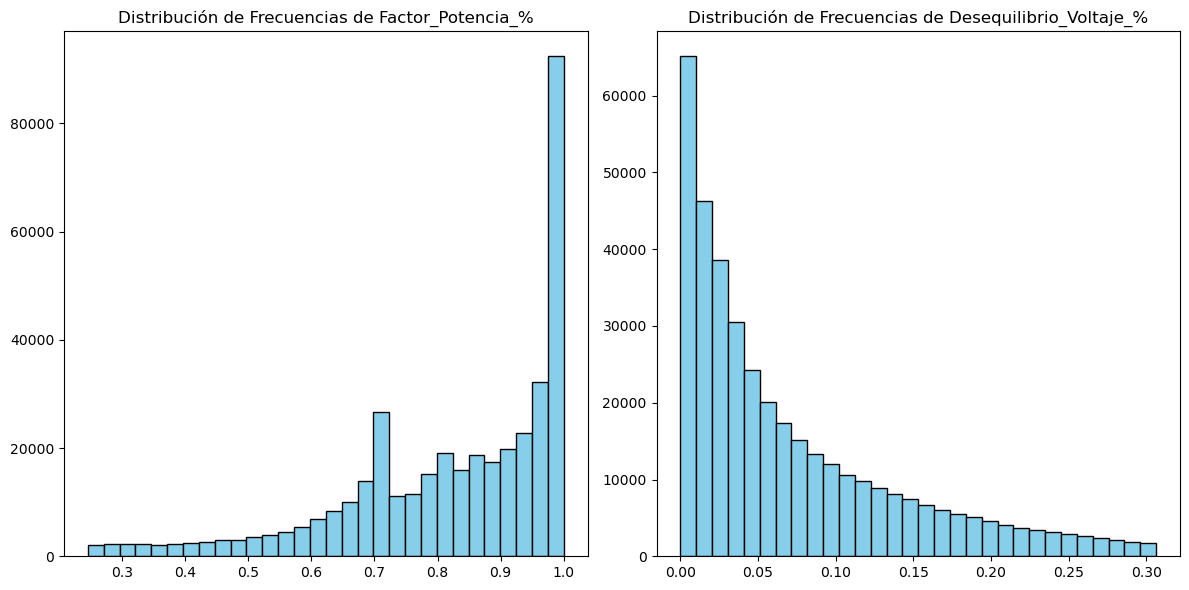

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated_sin_outliers_v1_IQR.csv')

# Filtrar el dataframe para incluir solo los valores que no son outliers
df = df[(df['Anomalia_FP'] == 0) & (df['Anomalias_Voltaje'] == 0)]

# Crear una figura con múltiples subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Crear un histograma para 'Factor_Potencia_%'
axs[0].hist(df['Factor_Potencia_%'], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribución de Frecuencias de Factor_Potencia_%')

# Crear un histograma para 'Desequilibrio_Voltaje_%'
axs[1].hist(df['Desequilibrio_Voltaje_%'], bins=30, color='skyblue', edgecolor='black')
axs[1].set_title('Distribución de Frecuencias de Desequilibrio_Voltaje_%')

# Mostrar la figura con todos los subplots
plt.tight_layout()
plt.show()


Probamos también Z-Score para tratar outliers GLOBALMENTE, pero no obtuvimos mejor resultado que usando IQR.


Por lo tanto, finalmente tratamos outliers con IQR pero ahora por cada SECTOR, dado que cada uno puede tener eficiencias de FP o voltaje distintas.

In [21]:
import pandas as pd
import numpy as np

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated.csv')

# Función para calcular el IQR y detectar outliers
def detect_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((group < (Q1 - 1.5 * IQR)) | (group > (Q3 + 1.5 * IQR))).astype(np.int)
    return outliers

# Calcular el IQR y detectar outliers para 'Factor_Potencia_%' por cada sector
df['Anomalia_FP'] = df.groupby('Sector')['Factor_Potencia_%'].transform(detect_outliers)

# Calcular el IQR y detectar outliers para 'Desequilibrio_Voltaje_%' por cada sector
df['Anomalias_Voltaje'] = df.groupby('Sector')['Desequilibrio_Voltaje_%'].transform(detect_outliers)

# Guardar el dataframe modificado en un nuevo archivo .csv
df.to_csv('Dataframes_all_consolidated_sin_outliers_v1_IQR_By_Sector.csv', index=False)


C:\Users\joseh\AppData\Local\Temp\ipykernel_14744\2716241914.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  outliers = ((group < (Q1 - 1.5 * IQR)) | (group > (Q3 + 1.5 * IQR))).astype(np.int)
C:\Users\joseh\AppData\Local\Temp\ipykernel_14744\2716241914.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish 

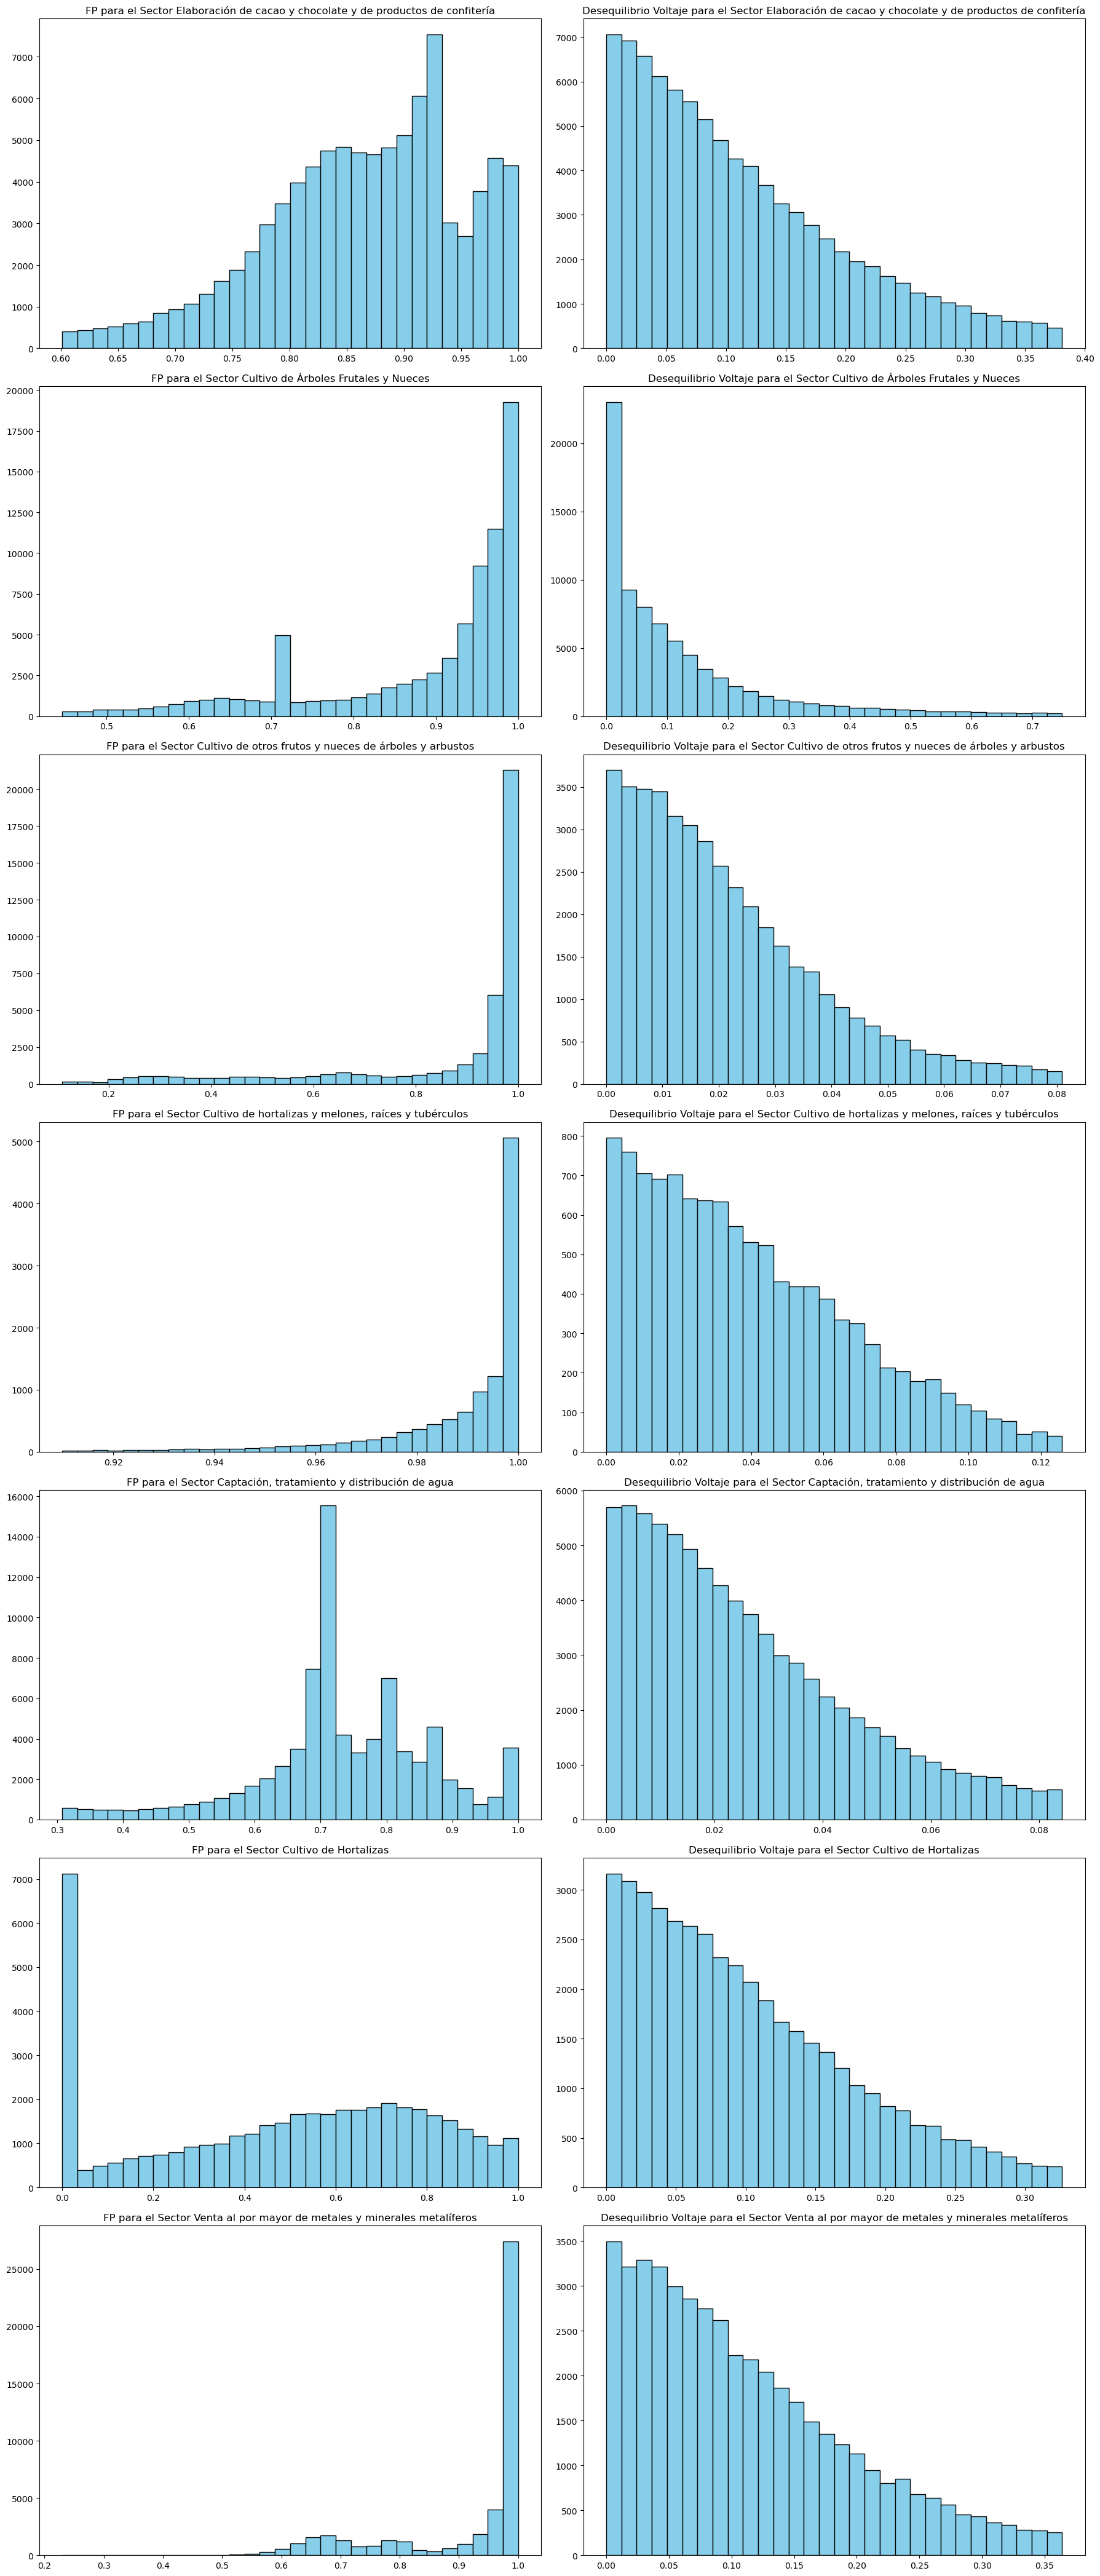

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated_sin_outliers_v1_IQR_By_Sector.csv')

# Obtener la lista de sectores únicos
sectores = df['Sector'].unique()

# Crear una figura con múltiples subplots
fig, axs = plt.subplots(len(sectores), 2, figsize=(18, 6*len(sectores)))

for i, sector in enumerate(sectores):
    # Filtrar el dataframe por sector y por valores que no son outliers
    df_sector = df[(df['Sector'] == sector) & (df['Anomalia_FP'] == 0) & (df['Anomalias_Voltaje'] == 0)]

    # Crear un histograma para 'Factor_Potencia_%' para el sector actual
    axs[i, 0].hist(df_sector['Factor_Potencia_%'], bins=30, color='skyblue', edgecolor='black')
    axs[i, 0].set_title(f'FP para el Sector {sector}')

    # Crear un histograma para 'Desequilibrio_Voltaje_%' para el sector actual
    axs[i, 1].hist(df_sector['Desequilibrio_Voltaje_%'], bins=30, color='skyblue', edgecolor='black')
    axs[i, 1].set_title(f'Desequilibrio Voltaje para el Sector {sector}')

# Mostrar la figura con todos los subplots
plt.tight_layout()
plt.show()


Tras gestionar los outliers en cada sector, avanzaremos hacia la clusterización por cliente, teniendo en cuenta que cada uno podría presentar características distintas en términos de energía y voltaje. Nuestro experimento se centrará en un enfoque específico de clusterización. Para ello, implementaremos el algoritmo k-means con un valor de k=2. El centroide inicial se establecerá en los valores óptimos de las variables de interés: el Factor de Potencia (FP) y el Desequilibrio de Voltaje (DV). En este escenario, el valor óptimo para el FP es 1 y para el DV es 0. Nuestra meta es agrupar los datos de cada cliente en dos clusters: uno que se aproxime al rendimiento óptimo y otro que se aleje de él.

En el contexto de este experimento de agrupación, nuestra primera opción es el algoritmo de K-means. Sin embargo, es importante recordar que un centroide inicializado en (1, 0) puede desplazarse durante la ejecución del algoritmo, y no hay garantía de que termine exactamente en nuestro centroide óptimo (1, 0). Esto se debe a que, en este algoritmo, los centroides se ubican inicialmente en una localización específica y luego se actualizan iterativamente con el objetivo de minimizar la suma de las distancias al cuadrado entre cada punto de datos y su centroide más cercano.

Tras experimentar, nos dimos cuenta de que el experimento requiere que uno de los grupos esté centrado precisamente en (1, 0), por lo que consideramos una estrategia alternativa. Este método se conoce como clasificación basada en distancia o clasificación basada en reglas, donde los puntos de datos se podrían clasificar en función de su distancia a este centroide.

En este enfoque, se calcula la distancia euclidiana de cada punto al centroide (1, 0) y luego se clasifican los puntos en dos grupos dependiendo de si su distancia al centroide es mayor o menor que la mediana de todas las distancias. Este proceso será llevado a cabo por el siguiente código que se va a ejecutar. Esta podría ser una solución viable para el experimento de agrupación que estamos evaluando.

El siguiente código está diseñado para calcular la distancia de Mahalanobis de cada punto respecto al centroide (1, 0). Posteriormente, se realiza una clasificación de los puntos en dos categorías. Esta clasificación se basa en si la distancia de Mahalanobis de un punto supera un umbral específico.

El umbral se determina a partir del cuantil de la distribución chi cuadrado con un nivel de significancia de 0.01. Los puntos que tienen una distancia de Mahalanobis mayor al umbral se identifican como 1, lo que indica que son anomalías. Por otro lado, los puntos que no superan el umbral se etiquetan como 0, lo que indica que son normales.

Es importante destacar que al establecer un nivel de significancia de 0.01, estamos aceptando un 1% de probabilidad de clasificar incorrectamente un punto como anomalía. En otras palabras, estamos 99% seguros de que un punto etiquetado como anomalía es realmente una anomalía. Esta medida nos proporciona un alto grado de confianza en la precisión de nuestra clasificación.

La Distancia de Mahalanobis es una medida de distancia que tiene en cuenta la correlación entre las variables y la variabilidad de cada variable. Esto la hace particularmente útil en situaciones donde las variables no son independientes o no tienen la misma variabilidad.

Aquí te dejo algunas razones por las que podrías preferir la distancia de Mahalanobis sobre otras medidas de distancia:

1. Correlación entre variables: A diferencia de la distancia euclidiana, la distancia de Mahalanobis tiene en cuenta la correlación entre las variables. Si las variables están altamente correlacionadas, la distancia euclidiana puede inflar la distancia entre los puntos, mientras que la distancia de Mahalanobis proporcionará una medida de distancia más precisa.
2. Escala de las variables: La distancia de Mahalanobis es invariante a las transformaciones lineales de los datos, lo que significa que no se ve afectada por la escala de las variables. Por otro lado, la distancia euclidiana y otras medidas de distancia pueden ser sensibles a la escala de las variables.
3. Identificación de outliers: La distancia de Mahalanobis es útil para identificar outliers en conjuntos de datos multivariados. Los puntos que están lejos del centroide en términos de la distancia de Mahalanobis pueden ser considerados outliers.
4. Comparación con un punto específico: Cuando se calcula la distancia a un punto específico (como un centroide), la distancia de Mahalanobis puede ser más apropiada que el Z-score. El Z-score mide cuántas desviaciones estándar está un punto de la media, pero no es una medida de distancia en el sentido tradicional.

In [23]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import chi2

# Cargar el dataframe
df = pd.read_csv('Dataframes_all_consolidated_sin_outliers_v1_IQR_By_Sector.csv')

# Filtrar el dataframe para incluir solo los valores que no son outliers
df = df[(df['Anomalia_FP'] == 0) & (df['Anomalias_Voltaje'] == 0)]

# Calcular la matriz de covarianza inversa
cov_inv = np.linalg.inv(df[['Factor_Potencia_%', 'Desequilibrio_Voltaje_%']].cov())

# Calcular la distancia de Mahalanobis de cada punto al centroide (1, 0)
df['Distancia'] = df.apply(lambda row: distance.mahalanobis([row['Factor_Potencia_%'], row['Desequilibrio_Voltaje_%']], [1, 0], cov_inv), axis=1)

# Calcular el cuantil de la distribución chi cuadrado para un nivel de significancia de 0.01
threshold = chi2.ppf((1 - 0.01), df=2)

# Clasificar los puntos según su distancia de Mahalanobis
df['Cluster'] = (df['Distancia'] > np.sqrt(threshold)).astype(int)

# Guardar el dataframe modificado en un nuevo archivo .csv
df.to_csv('Exploracion_clusterizacion_centroide_cliente_v3.csv', index=False)

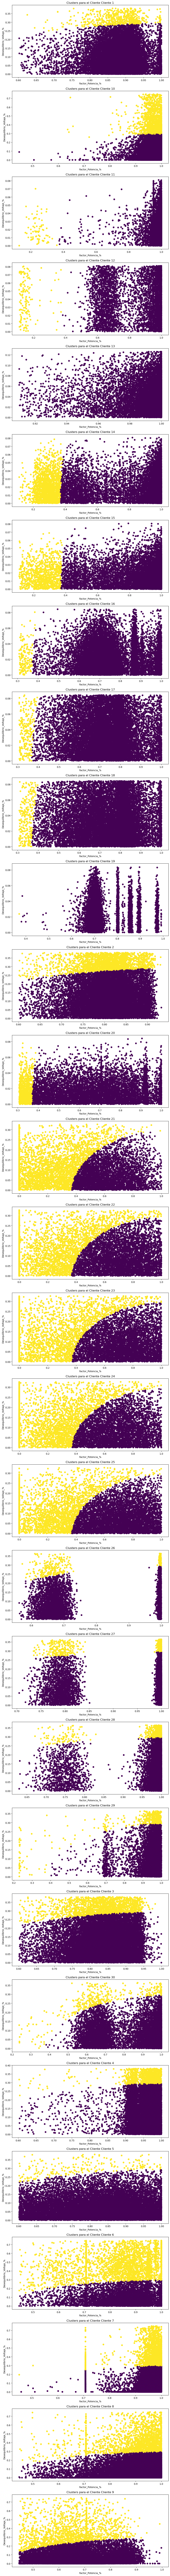

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataframe
df = pd.read_csv('Exploracion_clusterizacion_centroide_cliente_v3.csv')

# Obtener la lista de clientes únicos
clientes = df['Cliente'].unique()

# Crear una figura con múltiples subplots
fig, axs = plt.subplots(len(clientes), 1, figsize=(10, 5*len(clientes)))

for i, cliente in enumerate(clientes):
    # Filtrar el dataframe por cliente
    df_cliente = df[df['Cliente'] == cliente]

    # Crear un scatterplot para 'Factor_Potencia_%' y 'Desequilibrio_Voltaje_%' para el cliente actual
    axs[i].scatter(df_cliente['Factor_Potencia_%'], df_cliente['Desequilibrio_Voltaje_%'], c=df_cliente['Cluster'])
    axs[i].set_title(f'Clusters para el Cliente {cliente}')
    axs[i].set_xlabel('Factor_Potencia_%')
    axs[i].set_ylabel('Desequilibrio_Voltaje_%')

# Mostrar la figura con todos los subplots
plt.tight_layout()
plt.show()